In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [59]:
def u0_gaussian(z, G_w = 0.5, G_a = 1, z_s = 100):
    return G_a*(np.exp(-((z - z_s)/G_w)**2) - np.exp(-((-z - z_s)/G_w)**2))

def c_given(f, r, z):
    # load in SSP table
    ssp_filename = '2017-002-FA_CTD24.svp'
    ssp_full_filename = '/Users/matthewcasali/Documents/PythonScripts/acoustic-models/SSP_USGS/' + ssp_filename
    try:
        with open(ssp_full_filename, 'r') as file:
            content = file.read()
            content = content.split('\n')[3:-1]
            content = [item.split(' ') for item in content]
            converted_list = np.array([[float(item) for item in sublist] for sublist in content])
            z_ssp = converted_list[:,0] # [m] corresponding vertical coordinates for ssp
            ssp = converted_list[:,1] # [m/s] sound speed profile, https://doi.org/10.5066/P9Y1MSTN
            ssp_cs = scipy.interpolate.CubicSpline(z_ssp, ssp)
    except FileNotFoundError:
        print(f"Error: {file} was not found.", file = ssp_filename)
    c_start = ssp_cs(z)
    c = np.tile(np.append(np.append(1e-6, c_start), c_start[-1]), (np.size(r),1))
    return c 

In [60]:
def ifd_pe(f, r, z, c_func, u0_func, k = None, h = None):

    # initiate constants
    if type(h) == type(None):
        h = c_func(f, np.zeros(10), np.zeros(10))[1,1]/f/3 # [m] step size in depth
        z = np.arange(0,z[-1],h)
    if type(k) == type(None):
        k = c_func(f, np.zeros(10), np.zeros(10))[1,1]/f/15
        r = np.arange(0,r[-1],k)

    # define density profile
    rho = 1000*np.ones((np.size(r), np.size(z)+2))
    rho_0 = rho[0,0]
    
    # define attenuation profile
    alpha = np.zeros((np.size(r), np.size(z)+2))

    # define sound speed profile
    c = c_func(f, r, z)
    c_0 = 1500
    k_0   = 2*np.pi*f/c_0 # [1/m]

    # initialize field array
    u = np.zeros((np.size(r), np.size(z)+2))*(1 + 1j)

    # get initial field
    u[0,1:-1] = u0_func(z)

    # define refractive index
    n = (c_0/c)**2 + 1j*(c_0/c)**2 * alpha/27.287527

    # define bottom slope
    theta = 0*np.ones_like(r) # [rad]

    # iterator over range
    nn = 0

    pbar = tqdm(total = np.size(r)-1, position = 0, leave = True)
    while nn < np.size(r)-1:

        rows = np.arange(np.size(z))
        cols = np.arange(np.size(z))

        # compute main diagonals
        # -----
        a = 1j/2*k_0*(n**2 - 1)
        b = 1j/(2*k_0) * np.ones_like(n)

        if k < 0.1 * 2/np.max(np.abs(b)/h**2) and nn == 0:
            print('Solution is stable!')
    
        P = 1 / (1/b[:,1:-1] + (rho[:,1:-1]/rho[:,2:])*(1/b[:,2:]))
        Q = (a[:,1:-1]/b[:,1:-1] + (rho[:,1:-1]/rho[:,2:])*(a[:,2:]/b[:,2:]))
        
        X = h**2/(k*P) - (h**2/2*Q - (rho[:,1:-1]/rho[:,2:] + 1))
        Y = h**2/(k*P) + (h**2/2*Q - (rho[:,1:-1]/rho[:,2:] + 1))

        # get bottom conditions
        # ----- 
        bottom_c = b[:,-1]*np.tan(theta) / (h - b[:,-1]*np.tan(theta)) # 1/h when theta = 0
        bottom_d = (np.tan(theta)*(a[:,-1] + 1j*k) - 2*b[:,-1]/h**2) / (1/h - b[:,-1]*np.tan(theta)/h**2) # -2b/h when theta = 0

        # populate tri-diagonal matrices
        A = np.diag(X[nn+1,:]) # M x M                                                             
        A[rows[:-1],cols[1:]] = -rho[nn,1:-2]/rho[nn,2:-1]
        A[rows[1:], cols[:-1]] = -1*np.ones_like(rho[nn,1:-2])
        A[-1,-1] += bottom_d[nn+1]
        A[-2,-1] += bottom_c[nn+1]       
    
        B = np.diag(Y[nn,:]) # M x M
        B[rows[:-1], cols[1:]] = rho[nn,1:-2]/rho[nn,2:-1]
        B[rows[1:], cols[:-1]] = np.ones_like(rho[nn,1:-2])
        B[-1,-1] -= bottom_d[nn]
        B[-2,-1] -= bottom_c[nn]

        b = B@u[nn,1:-1]
        b = b[:,np.newaxis]

        u[nn+1,1:-1] = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(A), scipy.sparse.csr_matrix(b))

        nn += 1
        pbar.update(1)

    pbar.close()
  
    return [u, r, z]


In [ ]:
# defining depth and range
z = np.arange(0,750) # [m]
r = np.arange(0,5000) # [m]
f = 100 # [Hz]

[u,r,z] = ifd_pe(f, r, z, c_given, u0_gaussian)

  0%|                                          | 4/4915 [00:00<02:25, 33.68it/s]

Solution is stable!


  8%|███▏                                    | 386/4915 [00:12<02:36, 28.91it/s]

/var/folders/s9/9y8g5pr93wxf164_1zjdfvz00000gp/T/ipykernel_1277/3772417091.py:5: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(r, z, np.transpose(20*np.log10(np.abs(u[:,1:-1]/np.max(u[0,:])))), vmin = -60)


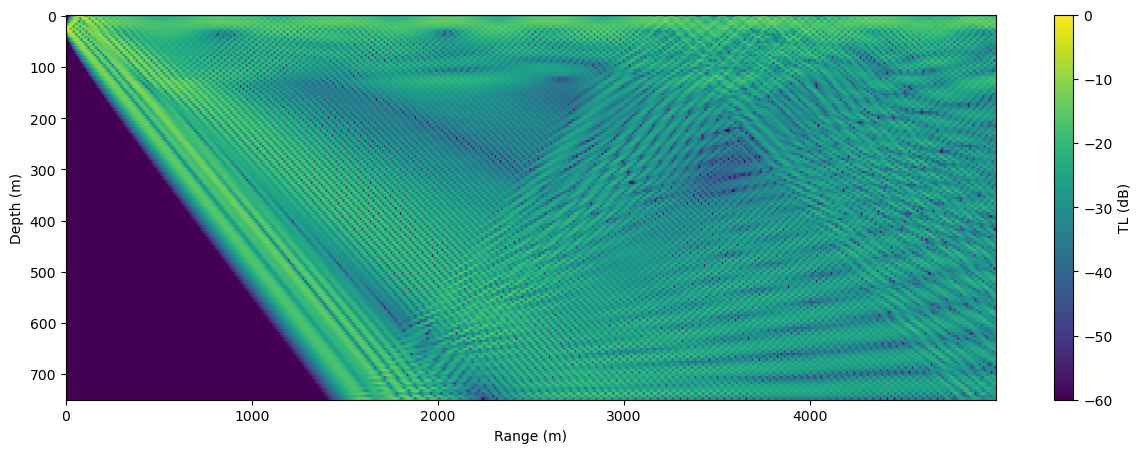

In [58]:
fig, ax = plt.subplots(figsize = (15,5))
plotR = np.append(r,r[-1]+7)
plotZ = np.append(z,z[-1]+0.1)
X, Y = np.meshgrid(plotR, plotZ)
im = ax.pcolormesh(r, z, np.transpose(20*np.log10(np.abs(u[:,1:-1]/np.max(u[0,:])))), vmin = -60)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Range (m)')
cbar = fig.colorbar(im, ax=ax, label='TL (dB)')

plt.savefig('/Users/matthewcasali/Documents/PythonScripts/acoustic-models/Figures/100Hz_5km.png')